# 1. RNN for the original whole dataset

In [1]:
# Import of required libraries and functions from 'make_dataset' script
import os
from make_dataset import Discotope_Dataset
import numpy as np
import torch
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm

C:\Users\minij\anaconda3\envs\special_course\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import tensorflow and keras
import tensorflow as tf
from tensorflow import keras

In [3]:
tf.random.set_seed(1234)

In [4]:
def data_load(name_set, data_dir, separate=False):
    
    '''
    Function to load training, validation or test data from the folder/directory you have storaged the whole dataset
        - 'name_set': text variable with the type of data set to load ('train', 'test', 'valid')
        - 'data_dir': directory where you have storaged the data set (in my case is '../Data/')
        - 'separate': boolean that returns the PDBs and AF2 sets separately (only when True)
    
    Output:
        - 'X_all': all observations from both solved and predicted structures all together
        - 'y_all': all labels from both solved and predicted structures all together
        - 'N_solved': number of observations from solved structures (in case of wanted to unmerge the 'all' array)
        - 'N_af2': number of observations from predicted structures (in case of wanted to unmerge the 'all' array)
    '''
    
    # 'Pathlib module' load to work with windows path
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    
    # List of all subdirectories inside the data directory
    dirs = [d for d in os.listdir(data_dir)]
    
    # 're' module to use regex for filtering the specific directories according to the type of data set to load
    pattern = '.*' + name_set + '.*'
    R = re.compile(pattern)
    filtered = [folder for folder in dirs if R.match(folder)]
    
    # Loading the data set for solved structures and AlphaFold2 predicted structures
    path_af2 = data_dir + filtered[0] + '/dataset.pt'
    path_solved = data_dir + filtered[1] + '/dataset.pt'
    set_af2 = torch.load(path_af2)
    set_solved = torch.load(path_solved)
    
    # Stack all features and targets to one big array
    X_set_solved = np.concatenate([sample["X_arr"] for sample in set_solved])
    y_set_solved = np.concatenate([sample["y_arr"] for sample in set_solved])
    X_set_af2 = np.concatenate([sample["X_arr"] for sample in set_af2])
    y_set_af2 = np.concatenate([sample["y_arr"] for sample in set_af2])
    
    # Nº of observations for each subtype of data set
    N_set_solved = X_set_solved.shape[0]
    N_set_af2 = X_set_af2.shape[0]
    
    # Stack all features and targets from solved and predicted structures into only one big
    X_set_all = np.concatenate((X_set_solved, X_set_af2), axis=0)
    y_set_all = np.concatenate((y_set_solved, y_set_af2), axis=0)
    
    if (separate==True):
        return(X_set_all, y_set_all, X_set_solved, y_set_solved, X_set_af2, y_set_af2)
    else:
        return(X_set_all, y_set_all, N_set_solved, N_set_af2)

In [5]:
def dataframe_load(name_set, data_dir):
    
    '''
    Function to load training, validation or test dataframes from the folder/directory you have storaged the whole dataset.
    This function is specifically to have the original dataframes of the data, and their corresponding description
        - 'name_set': text variable with the type of data set to load ('train', 'test', 'valid')
        - 'data_dir': directory where you have storaged the data set (in my case is '../Data/')
    
    Output:
        - 'set_af2': dataframe for AF2 predicted structures
        - 'set_solved': dataframe for PDB solved structures
    '''
    
    # 'Pathlib module' load to work with windows path
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    
    # List of all subdirectories inside the data directory
    dirs = [d for d in os.listdir(data_dir)]
    
    # 're' module to use regex for filtering the specific directories according to the type of data set to load
    pattern = '.*' + name_set + '.*'
    R = re.compile(pattern)
    filtered = [folder for folder in dirs if R.match(folder)]
    
    # Loading the data set for solved structures and AlphaFold2 predicted structures
    path_af2 = data_dir + filtered[0] + '/dataset.pt'
    path_solved = data_dir + filtered[1] + '/dataset.pt'
    set_af2 = torch.load(path_af2)
    set_solved = torch.load(path_solved)
    
    return(set_af2, set_solved)

In [6]:
def remove_NaN(data, y):
    
    '''
    Function to remove NaN values (some PDB entries have RSA NaN values)
        - 'data': numpy array with the specific (train, valid, test) data
        - 'y': numpy array with the specific (train, valid, test) labels
    
    Output:
        - 'data_noNaN': array withouth the entries/observations that contain NaN values
    '''
    
    # Merging X and y arrays all together
    joint_data = np.hstack((data, y.reshape(-1, 1)))
    
    # Removal of NaN entries
    nan_rows = np.isnan(joint_data).any(axis=1)
    data_noNaN = joint_data[~nan_rows, :]
    
    # Demerging the final array into X and y
    X_noNaN = data_noNaN[:, 0:data.shape[1]]
    y_noNaN = data_noNaN[:,-1]
    
    return(X_noNaN, y_noNaN)

In [7]:
def normalize_train(X):
    
    '''
    Function to normalize the columns 532 (pLLDT) and 533 (length) because they have high length
        - 'X': data to normalize
    '''
    
    # Create a copy of the X vector to do the normalization
    X_scaled = X.copy()
    
    # Create an instance of MinMaxScaler
    scaler = StandardScaler()
    
    # Fit the scaler to the data 
    #scaler.fit(X_scaled[:, 532:534])
    scaler.fit(X_scaled)
    
    # Transform the data
    #X_scaled[:, 532:534] = scaler.fit_transform(X_scaled[:, 532:534])
    X_scaled = scaler.fit_transform(X_scaled)
    return(X_scaled)

In [8]:
def Z_transform_train(X):
    
    '''
    Function to normalize the columns 532 (pLLDT) and 533 (length) because they have high length
        - 'X': data to normalize
    '''
    
    # Obtain the mean and standard deviation for each feature on the array
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    
    # Z-transform (standardization)
    X_scaled = (X - X_mean)/X_std
    return(X_scaled, X_mean, X_std)

In [9]:
def Z_transform_valid(X, mean_train, sd_train):
    
    '''
    Function to normalize the columns 532 (pLLDT) and 533 (length) because they have high length
        - 'X': data to normalize
        - 'mean_train': mean from standardized training set
        - 'sd_train': standard deviation from standardized training set
    '''
    
    # Z-transform (standardization)
    X_scaled = (X - mean_train)/sd_train
    return(X_scaled)

In [10]:
def class_weight_calculator(y_train):
        
    '''
    Function to calculate the class weights for the unbalanced data
        - 'y_train': training labels (contains 0 and 1)
    '''
    
    # Compute the class weights with sklearn function
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

    # Convert the class weights to a dictionary
    class_weight = dict(enumerate(class_weights))
    return(class_weight)

In [25]:
# Neuronal network model with one layer
def nn_model(train_data, y_train, valid_data, y_valid, loss_fun, alpha, class_weight_fn):
    
    '''
    Function to create and train/validate the feed-forward neuronal network with only 1 hidden layer
        -'train_data': X train standardized
        -'y_train': training labels
        -'valid_data': X validation standardized
        -'y_valid': validation labels
        -'act_fun': activation function
        -'loss_fun': loss function
        -'class_weight_calculator': function to calculate the weights for each class
    
    Output:
        -'model': neural network model trained
        -'history': attributes obtained during fitting the model
    '''
    
    # Calculation of the class weights with function previously defined
    class_weight = class_weight_fn(y_train)
    
    # Normalization of the class_weight to sum 1
    tot = class_weight[0] + class_weight[1]
    class_weight[0] = class_weight[0]/tot
    class_weight[1] = class_weight[1]/tot
    
    # Implementation of keras for creating a sequential model with 1 layer
    tf.random.set_seed(1234)
    from keras.layers import Dense, Dropout
    from keras import regularizers, metrics
    
    model = keras.Sequential()
    # Input layer with train_data.shape neurons and a hidden layer with 1 neuron
    model.add(Dense(1, activation='relu', input_shape=train_data.shape[1:], kernel_regularizer=regularizers.l2(alpha)))
    # Output layer with sigmoid activation (better for binary classification)
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(alpha)))
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss=loss_fun, metrics=
                  ['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC(), loss_fun])
    
    history = model.fit(train_data, y_train, epochs = 50, batch_size=128, verbose=0, class_weight=class_weight, 
                        validation_data = (valid_data, y_valid))
    
    return(model, history)

In [12]:
def loss_plot(loss_values):
    
    '''
    Function to plot the loss curve of the training of the model
        - 'loss_values': array with the loss values for each iteration of the training
    '''
    
    plt.plot(loss_values, label = 'Train')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

In [13]:
def ROC_AUC(y_true, y_hat):
    
    '''
    Function to obtain the AUC value based on the ROC curve
        - 'y_true': y original values
        - 'y_hat': y predicted values
        
    Output:
        - 'ROC_auc': AUC value
    '''
    
    fpr, tpr, _ = metrics.roc_curve(y_true, y_hat)
    ROC_auc = metrics.auc(fpr, tpr)
    return(ROC_auc)

In [14]:
def PR_AUC(y_true, y_hat):
    
    '''
    Function to obtain the AUC value based on the precision and recall parameters
        - 'y_true': y original values
        - 'y_hat': y predicted values
        
    Output:
        - 'PR_auc': AUC value
    '''
    
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_hat)
    PR_auc = metrics.auc(recall, precision)
    return(PR_auc)

In [15]:
# Epitope rank percentile score
# https://github.com/Magnushhoie/discotope3/blob/main/src/models/mlscripts.py#L55

def get_percentile_score_arr(
    scores: np.array,
    epitopes: np.array,
):
    
    """Find mean predicted epitope rank percentile score from the scores (y_hat) and the epitopes (y_true)"""
    epitopes_bool = epitopes.astype(bool)
    assert epitopes_bool.dtype == "bool"

    c = scores[epitopes_bool].mean()
    c_percentile = (c > scores).mean()

    return c_percentile

In [16]:
# Data loading for training, validation, and test data sets (needs a couple of minutes)
X_train, y_train, X_train_PDB, y_train_PDB, X_train_af2, y_train_af2 = data_load(name_set='train', data_dir='../Data/', separate = True)
X_valid, y_valid, X_valid_PDB, y_valid_PDB, X_valid_af2, y_valid_af2 = data_load(name_set='valid', data_dir='../Data/', separate = True)
X_test, y_test, X_test_PDB, y_test_PDB, X_test_af2, y_test_af2 = data_load(name_set='test', data_dir='../Data/', separate = True)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((480297, 536), (480297,), (119792, 536), (119792,), (14084, 536), (14084,))

In [17]:
# Data manipulation to remove all PDB entries with NaN values in the RSA feature (535)
X_train, y_train = remove_NaN(data=X_train, y=y_train)
X_valid, y_valid = remove_NaN(data=X_valid, y=y_valid)
X_test, y_test = remove_NaN(data=X_test, y=y_test)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((463580, 536), (463580,), (118084, 536), (118084,), (12983, 536), (12983,))

In [18]:
# Data normalization of features 532 (pLLDT) and 533 (length)
X_train_sc, mean_X_train, sd_X_train = Z_transform_train(X_train)
X_valid_sc = Z_transform_valid(X_valid, mean_X_train, sd_X_train)
X_test_sc = Z_transform_valid(X_test, mean_X_train, sd_X_train)

X_train_sc.shape, X_valid_sc.shape, X_test_sc.shape

((463580, 536), (118084, 536), (12983, 536))

In [19]:
# Class unbalanced in train
zero, one = np.bincount(y_train.astype(int))
total = zero + one
print("Class count (train):\n\n      Total: {}\n      Epitope label: {} ({:.2f}% of total)".format(total, one, 100*one/total))

Class count (train):

      Total: 463580
      Epitope label: 42458 (9.16% of total)


In [20]:
# Class unbalanced in valid
zero, one = np.bincount(y_valid.astype(int))
total = zero + one
print("Class count (validation):\n\n      Total: {}\n      Epitope label: {} ({:.2f}% of total)".format(total, one, 100*one/total))

Class count (validation):

      Total: 118084
      Epitope label: 9810 (8.31% of total)


In [21]:
# Class unbalanced in train
zero, one = np.bincount(y_test.astype(int))
total = zero + one
print("Class count (test):\n\n      Total: {}\n      Epitope label: {} ({:.2f}% of total)".format(total, one, 100*one/total))

Class count (test):

      Total: 12983
      Epitope label: 792 (6.10% of total)


In [26]:
# Parameters definition
loss = 'binary_crossentropy'
l2_value = 0.01

# Training and validation of the model
model, history = nn_model(train_data=X_train_sc, y_train=y_train, valid_data=X_valid_sc, y_valid=y_valid, 
                          loss_fun=loss, alpha=l2_value, class_weight_fn=class_weight_calculator)

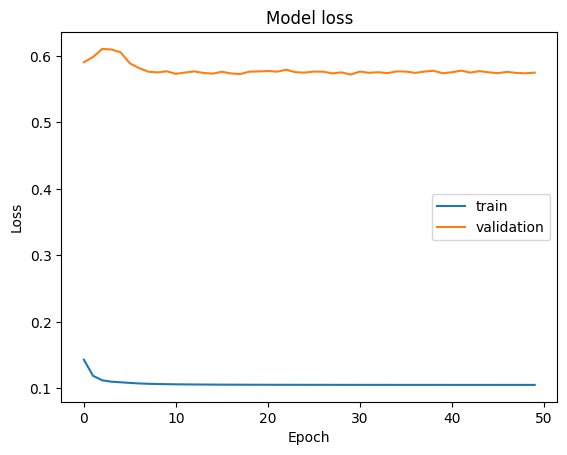

In [40]:
# Summarize history for loss
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

In [28]:
# Metrics from the model
metrics_names = model.metrics_names
metrics_values = model.evaluate(X_valid_sc, y_valid)

for name, value in zip(metrics_names, metrics_values):
    print(name, ':', value)

3691/3691 [==============================] - 8s 2ms/step - loss: 0.5749 - accuracy: 0.6752 - precision_2: 0.1676 - recall_2: 0.7339 - auc_2: 0.7755 - binary_crossentropy: 0.5670
loss : 0.5748986601829529
accuracy : 0.6751719117164612
precision_2 : 0.16764849424362183
recall_2 : 0.7339449524879456
auc_2 : 0.7754640579223633
binary_crossentropy : 0.5669654011726379


In [59]:
# Obtaining probabilities values
y_pred_valid_prob = model.predict(X_valid_sc)

# Conversion to 0 or 1 labels (0.5 threshold)
y_pred_valid = (y_pred_valid_prob > 0.5).astype(int)

3691/3691 [==============================] - 6s 2ms/step


In [60]:
# Count of '0' in the valid and the prediction
np.count_nonzero(y_valid == 0), np.count_nonzero(y_pred_valid == 0)

(108274, 75137)

In [61]:
# Count of '1' in the valid and the prediction
np.count_nonzero(y_valid == 1), np.count_nonzero(y_pred_valid == 1)

(9810, 42947)

In [62]:
y_pred_valid

array([[1],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [63]:
# Evaluate the model's performance
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
print(f'Valid accuracy: {accuracy_valid:.5f}')

Valid accuracy: 0.67517


In [64]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, y_pred_valid)

array([[72527, 35747],
       [ 2610,  7200]], dtype=int64)

In [65]:
# AUC value (valid)
ROC_AUC_valid = ROC_AUC(y_valid, y_pred_valid_prob)
PR_AUC_valid = PR_AUC(y_valid, y_pred_valid_prob)
print(f'(ROC)AUC value for the validation data: {ROC_AUC_valid:.3f}')
print(f'(PR)AUC value for the validation data: {PR_AUC_valid:.3f}')

(ROC)AUC value for the validation data: 0.776
(PR)AUC value for the validation data: 0.237


In [66]:
from sklearn.metrics import roc_auc_score
auc_valid = roc_auc_score(y_valid, y_pred_valid_prob)
print('Validation AUC:', auc_valid)

Validation AUC: 0.7755062881110872


In [67]:
# Epitope rank (valid)
c_percentile_valid = get_percentile_score_arr(scores = y_pred_valid, epitopes = y_valid)
c_percentile_valid

0.6363012770570102

In [74]:
print('False positive ratio:', confusion_matrix(y_valid, y_pred_valid)[0][1]/len(y_valid))

False positive ratio: 0.30272517868635884


In [78]:
pd.DataFrame(X_valid_sc[:, 512:]).describe()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
count,118084.000000,118084.000000,118084.000000,118084.000000,118084.000000,118084.000000,118084.000000,118084.000000,118084.000000,118084.000000,...,118084.000000,118084.000000,118084.000000,118084.000000,118084.000000,118084.000000,118084.000000,118084.000000,118084.000000,118084.000000
mean,0.030735,-0.006413,-0.016117,0.008816,-0.027986,0.032439,-0.008042,0.003230,-0.013860,0.010028,...,0.013225,-0.006994,-0.003578,0.006770,0.014987,-0.030313,0.114893,0.044084,-0.021855,-0.030133
std,1.054753,0.982748,0.966172,1.016889,0.935639,1.052854,0.973852,1.006075,0.972854,1.014922,...,1.028846,0.987984,0.993617,1.011418,1.052383,0.924405,0.817387,0.973777,1.000559,0.999383
min,-0.253525,-0.181479,-0.230336,-0.243042,-0.215547,-0.273908,-0.152373,-0.248631,-0.244214,-0.302159,...,-0.214933,-0.271648,-0.261953,-0.272444,-0.136528,-0.201199,-7.042226,-1.553949,-1.036988,-1.183899
25%,-0.253525,-0.181479,-0.230336,-0.243042,-0.215547,-0.273908,-0.152373,-0.248631,-0.244214,-0.302159,...,-0.214933,-0.271648,-0.261953,-0.272444,-0.136528,-0.201199,0.081265,-0.701550,-1.036988,-0.977368
50%,-0.253525,-0.181479,-0.230336,-0.243042,-0.215547,-0.273908,-0.152373,-0.248631,-0.244214,-0.302159,...,-0.214933,-0.271648,-0.261953,-0.272444,-0.136528,-0.201199,0.409537,0.084771,0.964331,-0.185783
75%,-0.253525,-0.181479,-0.230336,-0.243042,-0.215547,-0.273908,-0.152373,-0.248631,-0.244214,-0.302159,...,-0.214933,-0.271648,-0.261953,-0.272444,-0.136528,-0.201199,0.521535,0.679468,0.964331,0.696113
max,3.944389,5.510285,4.341478,4.114523,4.639350,3.650864,6.562829,4.022018,4.094769,3.309512,...,4.652612,3.681229,3.817473,3.670477,7.324488,4.970215,0.521535,3.580266,0.964331,4.776337


In [80]:
pd.DataFrame(X_valid_sc[:, 512:])

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-0.253525,-0.181479,-0.230336,-0.243042,-0.215547,-0.273908,-0.152373,-0.248631,-0.244214,-0.302159,...,4.652612,-0.271648,-0.261953,-0.272444,-0.136528,-0.201199,0.521535,0.672860,-1.036988,1.219883
1,-0.253525,-0.181479,4.341478,-0.243042,-0.215547,-0.273908,-0.152373,-0.248631,-0.244214,-0.302159,...,-0.214933,-0.271648,-0.261953,-0.272444,-0.136528,-0.201199,0.521535,0.672860,-1.036988,1.256222
2,-0.253525,-0.181479,-0.230336,-0.243042,4.639350,-0.273908,-0.152373,-0.248631,-0.244214,-0.302159,...,-0.214933,-0.271648,-0.261953,-0.272444,-0.136528,-0.201199,0.521535,0.672860,-1.036988,-0.554929
3,-0.253525,-0.181479,-0.230336,-0.243042,-0.215547,-0.273908,-0.152373,-0.248631,-0.244214,-0.302159,...,-0.214933,-0.271648,-0.261953,-0.272444,-0.136528,-0.201199,0.521535,0.672860,-1.036988,-0.591440
4,-0.253525,-0.181479,-0.230336,-0.243042,-0.215547,-0.273908,-0.152373,-0.248631,-0.244214,-0.302159,...,-0.214933,-0.271648,-0.261953,-0.272444,-0.136528,-0.201199,0.521535,0.672860,-1.036988,0.041361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118079,-0.253525,-0.181479,-0.230336,-0.243042,-0.215547,3.650864,-0.152373,-0.248631,-0.244214,-0.302159,...,-0.214933,-0.271648,-0.261953,-0.272444,-0.136528,-0.201199,-2.917591,-1.177308,0.964331,0.938345
118080,-0.253525,-0.181479,-0.230336,-0.243042,-0.215547,-0.273908,-0.152373,-0.248631,-0.244214,3.309512,...,-0.214933,-0.271648,-0.261953,-0.272444,-0.136528,-0.201199,-3.555789,-1.177308,0.964331,-0.198314
118081,-0.253525,-0.181479,-0.230336,4.114523,-0.215547,-0.273908,-0.152373,-0.248631,-0.244214,-0.302159,...,-0.214933,-0.271648,-0.261953,-0.272444,-0.136528,-0.201199,-4.350400,-1.177308,0.964331,1.618959
118082,-0.253525,-0.181479,-0.230336,-0.243042,-0.215547,-0.273908,-0.152373,-0.248631,-0.244214,-0.302159,...,-0.214933,-0.271648,-0.261953,3.670477,-0.136528,-0.201199,-5.570797,-1.177308,0.964331,1.940300


- AUC per feature
- Change activation and regularization
- Balancing VS not balancing
- Check feature normalization only in the relevant
- Include performance on validation and test
- Resampling from the training data or randoms value in the weights (later): ensemble
- Save dataframes of train, valid, test with regularization: no categorical variables